In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import linmix
from astropy.table import Table, Column
import astropy.io.ascii as ascii
#import corner
from lifelines import KaplanMeierFitter
from matplotlib import rc
from matplotlib.ticker import MultipleLocator

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#%matplotlib inline
%matplotlib qt5

In [2]:
##############################
##   Read TABLEs   ####
Tau_Tab=Table.read("Taurus_Tab_Full.fit")      
Lup_Tab_orig=Table.read('Lupus_Tab_Full.fit')     
ChaI_Tab=Table.read('ChaI_Tab_Full.fit')
UppSco_Tab=Table.read('UppSco_Tab_Full.fit')

#remove Sz82, it gives problem in Md and Mg...

Lup_Tab=Lup_Tab_orig.copy()
Lup_Tab.remove_row(14)

####  DUST #####
delta_Md_Tau=Tau_Tab['lMd']!='<'               
delta_Md_Lup=Lup_Tab['l_Md']!='<'
delta_Md_ChaI=ChaI_Tab['l_Md']!='<'
delta_Md_UppSco=UppSco_Tab['lMd']!='<' 
delta_Md_LupChaI=np.concatenate((delta_Md_Lup,delta_Md_ChaI))

logMd_Tau=Tau_Tab['LogMd']    # Md in Eart Mass
logMd_Lup=np.log10(Lup_Tab['Md'])
logMd_ChaI=np.log10(ChaI_Tab['Md'])   
logMd_UppSco=np.log10(UppSco_Tab['Md'])

####  GAS #####
delta_Mg_Lup=Lup_Tab['l_Mg']!='<'      #observed sources for Mgas
delta_Mg_ChaI=ChaI_Tab['l_Mg']!='<'      #observed sources for Mgas
logMg_Lup=Lup_Tab['logMg']
logMg_ChaI=ChaI_Tab['logMg']

####  GAS TO DUST RATIO #####
ratioLup=10**Lup_Tab['logMg']/(Lup_Tab['Md']/332946)    #332946 due to the conversion Mearth-Msol
ratioChaI=10**ChaI_Tab['logMg']/(ChaI_Tab['Md']/332946)
ratioLupChaI=np.concatenate((ratioLup,ratioChaI))
logRatioLupChaI=np.log10(ratioLupChaI)
logRatio_Lup=np.log10(ratioLup)
logRatio_ChaI=np.log10(ratioChaI)

In [46]:
#  choose the analysis to perform: dust mass or gas mass?    #
#n='dust'
#n='gas'
n='ratio'

In [70]:
## USE the KaplanMeierFitter to create the cumulative functions

#### DUST ######
if n=='dust':
    survey=['Taurus','Lupus','ChamI','Upper Scorpius']
    color=['magenta','blue','orange','green']
    C=[delta_Md_Tau,delta_Md_Lup,delta_Md_ChaI,delta_Md_UppSco] #NOT upper limits on DUST MASS
    Mass=[logMd_Tau,logMd_Lup,logMd_ChaI, logMd_UppSco]  #log DUST MASS
    mass_label='M$_d$ [M$_\oplus$]'
    cumul_label='f($>$M$_d$)'
    
#### GAS ###
if n=='gas':
    survey=['Lupus','ChaI']
    color=['blue','orange']
    C=[delta_Mg_Lup,delta_Mg_ChaI]
    Mass=[logMg_Lup,logMg_ChaI]
    mass_label='M$_g$ [M$_\odot$]'
    cumul_label='f($>$M$_g$)'
    
if n=='ratio':
    survey=('Lupus','ChaI')
    color=('blue','orange')
    C=[delta_Mg_Lup[delta_Md_Lup],delta_Mg_ChaI[delta_Md_ChaI]]
    Ratio=[ratioLup[delta_Md_Lup],ratioChaI[delta_Md_ChaI]]
    Mass=[]
    for i,val in enumerate(Ratio):
        Mass_tmp=np.log10(val)
        Mass.append(Mass_tmp)
    mass_label='M$_g$/M$_d$'
    cumul_label='f($>$M$_g$/M$_d$)'
    
    
len_surveys=len(survey)
_kmf=[]
s=[] #survival fuction --> cumulative
t=[] #timeline --> MDUST
Dn=[] #lower value range confidence level
Dp=[] #upper value range confidence level
median=[]

for j in range(len_surveys):
    kmf=KaplanMeierFitter()
    kmf_tmp=kmf.fit(10**Mass[j],event_observed=C[j],left_censorship=True,label='kmf',alpha=0.5)
    #survival fuction
    _kmf.append(kmf_tmp)
    s_tmp=1-_kmf[j].cumulative_density_.values.ravel()
    s.append(s_tmp)
    #timeline
    t_tmp=_kmf[j].timeline
    t.append(t_tmp)
    #lower value range confidence level
    Dp_tmp=_kmf[j].confidence_interval_['kmf_upper_0.50']-(1-s[j])
    Dp.append(Dp_tmp)
    Dn_tmp=(1-s[j])-_kmf[j].confidence_interval_['kmf_lower_0.50']
    Dn.append(Dn_tmp)

    median_tmp=(_kmf[j].cumulative_density_<= 0.5).idxmin(0)
    median.append(median_tmp)
    
for i,val in enumerate(median):
    print 'median_'+survey[i]+'= ',val

median_Lupus=  kmf    1.872226
dtype: float64
median_ChaI=  kmf    0.90125
dtype: float64


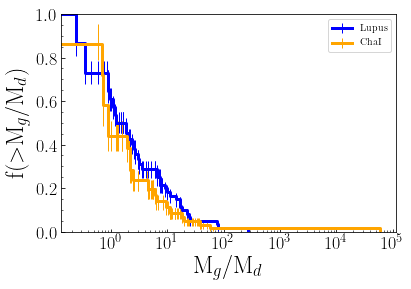

In [71]:
### PLOT Cumulative functions for DUST MASS

ax = plt.subplot(111)

for i in range(len_surveys):
    ax.errorbar(t[i],s[i],yerr=[Dn[i],Dp[i]],drawstyle='steps-post',linewidth=3,
                color=color[i],label=survey[i],elinewidth=1)
#ax.errorbar(t[0],kmf_Tau.cumulative_density_.values.ravel(),
#            yerr=[Dn[0],Dp[0]],drawstyle='steps-post',linewidth=3,elinewidth=1)
    
plt.legend()
plt.xscale('log')
plt.ylim(0, 1)
plt.minorticks_on()
ax.set_ylabel(cumul_label, fontsize=24)
ax.set_xlabel(mass_label,fontsize=24)   # Md is in Earth masses
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.show()
